In [1]:
import numpy as np
#from netCDF4 import Dataset as ncdset
import glob
import warnings
import datetime
import scipy.stats
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import os
import cdsapi
#from scipy.optimize import curve_fit
import xarray as xr
import xskillscore as xs
import pandas as pd
import xesmf as xesmf
import operator

In [2]:
def pnw_average(dataArray,latstr,lonstr):
    #Compute the latitude weighted average over the PNW
    datout = dataArray.where((dataArray[latstr] > 40.5) & (dataArray[latstr] < 50.5) &
                            (dataArray[lonstr] > 235.5) & (dataArray[lonstr] < 253.5),drop=True)
    weights = np.cos(np.deg2rad(datout[latstr]))
    weights.name = 'weights'
    datout_weighted = datout.weighted(weights).mean(dim=[latstr,lonstr],skipna=True)
    return datout_weighted

#computes the linear trend of precipitation and temperature (only used for SSP calculations)
def compute_trend(nci):
    #this bit is just because xarray doesn't recognize single valued dimensions
    if 'ens' in nci.variables:
        nens = len(nci['ens'])
    else:
        nens = 1
    month_length = nci.time.dt.days_in_month
    tmp = (nci['pr']*month_length)/10

    p = pnw_average(tmp,'lat','lon')
    p = p.groupby('time.year').sum(dim='time',skipna=False)
    t = pnw_average(nci['tas'],'lat','lon')
    t = t.groupby('time.year').mean(dim='time')
    ptmp = xs.linslope(p['year'],p,dim='year',skipna=False)*100
    ttmp = xs.linslope(t['year'],t,dim='year',skipna=False)*100
    ptrend = np.nanmean(ptmp)
    ttrend = np.nanmean(ttmp)
    
    return ptrend,ttrend,ptmp

In [3]:
# Load in metrics from file

diri = '/glade/work/nlybarger/data/hydromet/cmip6_metrics/'
filis = sorted(glob.glob('/glade/work/nlybarger/data/hydromet/cmip6_metrics/PNW/*PNW.nc'))
models = ['0']*len(filis)

for i in range(len(filis)):
    models[i] = filis[i].split('.')[-5].split('/')[-1]
    
#models = sorted(models)

metrics = {}
variants = {}
for mod in models:
    tmpfil = diri + 'PNW/' + mod + '.cmip6.metrics.PNW.nc'
    if os.path.exists(tmpfil):
        metrics[mod] = xr.open_dataset(tmpfil,engine='netcdf4')
        variants[mod] = list(metrics[mod]['ens'].data)
    else:
        continue
        
remmodels = ['KIOST-ESM','CIESM','E3SM-1-1']
for mod in remmodels:
    if mod in list(metrics.keys()):
        metrics.pop(mod)
        variants.pop(mod)
models = list(metrics.keys())

global_metrics = {}
for mod in models:
    tmpfil = diri + 'global/' + mod + '.cmip6.historical.global_metrics.nc'
    if os.path.exists(tmpfil):
        global_metrics[mod] = xr.open_dataset(tmpfil,engine='netcdf4')
    else:
        continue

In [ ]:
# Cycle through all perfect models and either load metrics from file where possible
# or compute metrics against all other models

tas_maplist = ['djf_t','mam_t','jja_t','son_t']
pr_maplist = ['djf_pr','mam_pr','jja_pr','son_pr']
enso_maplist = ['djf_n34_pr_scorr','djf_eli_pr_scorr','djf_n34_t_scorr','djf_eli_t_scorr']

with warnings.catch_warnings():
    warnings.simplefilter("ignore",category=RuntimeWarning)
    
    nmet = 52
    nens = 72

    nmod = len(models)
    modmet = np.full((nmod,nmod,nmet,nens),np.nan)
    errs = np.full((nmod,nmod,nmet,nens),np.nan)
    for i in range(nmod):
        pmod = models[i]
        print('Beginning perfect model evaluation for: ' + pmod)
        print('Progress: ' + str(round(((i+1)/nmod)*100,2)) + '%')
        for j in range(nmod):
            mod = models[j]
            if pmod == mod:
                continue
    ## Mean-T, Mean-P, Seasonal Amplitude-T, Seasonal Amplitude-P
            nensmod = len(metrics[mod]['ens'])
            k=0
            modmet[i,j,k,:nensmod] = metrics[mod]['meant']
            errs[i,j,k,:nensmod] = abs(modmet[i,j,k,:nensmod] - metrics[pmod]['meant'].mean(dim='ens',skipna=True).data)
            k+=1
            modmet[i,j,k,:nensmod] = metrics[mod]['meanp']
            errs[i,j,k,:nensmod] = abs(modmet[i,j,k,:nensmod] - metrics[pmod]['meanp'].mean(dim='ens',skipna=True).data)
            k+=1
            modmet[i,j,k,:nensmod] = metrics[mod]['sampt']
            errs[i,j,k,:nensmod] = abs(modmet[i,j,k,:nensmod] - metrics[pmod]['sampt'].mean(dim='ens',skipna=True).data)
            k+=1
            modmet[i,j,k,:nensmod] = metrics[mod]['sampp']
            errs[i,j,k,:nensmod] = abs(modmet[i,j,k,:nensmod] - metrics[pmod]['sampp'].mean(dim='ens',skipna=True).data)
            k+=1
            modmet[i,j,k,:nensmod] = metrics[mod]['ttrend']
            errs[i,j,k,:nensmod] = abs(modmet[i,j,k,:nensmod] - metrics[pmod]['ttrend'].mean(dim='ens',skipna=True).data)
            k+=1
            modmet[i,j,k,:nensmod] = metrics[mod]['ptrend']
            errs[i,j,k,:nensmod] = abs(modmet[i,j,k,:nensmod] - metrics[pmod]['ptrend'].mean(dim='ens',skipna=True).data)
            k+=1
        ## DJF Spatial Correlation with Obs for Nino3.4 and ELI for T and P
            pnens = len(metrics[pmod]['ens'])
            nens = len(metrics[mod]['ens'])
            #   (variables,seasons,model ensemble size,perfect model ensemble size)
            seas_scorrs = np.zeros((2,4,nens,pnens))
            seas_sstdev = np.zeros((2,4,nens,pnens))
            enso_scorrs = np.zeros((4,nens,pnens))
            for isea in range(4):
                for ie in range(nens):
                    for pe in range(pnens):
                        seas_scorrs[0,isea,ie,pe] = xs.pearson_r(metrics[mod][tas_maplist[isea]].sel(ens=variants[mod][ie],
                                                                drop=True),metrics[pmod][tas_maplist[isea]].sel(ens=variants[pmod][pe],
                                                                drop=True),dim=['lat','lon'],skipna=True).data
                        seas_scorrs[1,isea,ie,pe] = xs.pearson_r(metrics[mod][pr_maplist[isea]].sel(ens=variants[mod][ie],
                                                                drop=True),metrics[pmod][pr_maplist[isea]].sel(ens=variants[pmod][pe],
                                                                drop=True),dim=['lat','lon'],skipna=True).data
                        seas_sstdev[0,isea,ie,pe] = np.nanstd(metrics[mod][tas_maplist[isea]].sel(ens=variants[mod][ie],
                                                                drop=True).data)/np.nanstd(metrics[pmod][tas_maplist[isea]].sel(ens=variants[pmod][pe],
                                                                drop=True).data)
                        seas_sstdev[1,isea,ie,pe] = np.nanstd(metrics[mod][pr_maplist[isea]].sel(ens=variants[mod][ie],
                                                                drop=True).data)/np.nanstd(metrics[pmod][pr_maplist[isea]].sel(ens=variants[pmod][pe],
                                                                drop=True).data)

                        enso_scorrs[isea,ie,pe] = xs.pearson_r(metrics[mod][enso_maplist[isea]].sel(ens=variants[mod][ie],
                                                                drop=True),metrics[pmod][enso_maplist[isea]].sel(ens=variants[pmod][pe],
                                                                drop=True),dim=['lat','lon'],skipna=True).data
            seas_scorrs = np.nanmean(seas_scorrs,axis=3)
            seas_sstdev = np.nanmean(seas_sstdev,axis=3)
            enso_scorrs = np.nanmean(enso_scorrs,axis=2)
            
            modmet[i,j,k,:nensmod] = enso_scorrs[0,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = enso_scorrs[1,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = enso_scorrs[2,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = enso_scorrs[3,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
        ## Seasonal Spatial Correlation for T and P with Obs
            modmet[i,j,k,:nensmod] = seas_scorrs[0,0,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_scorrs[0,1,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_scorrs[0,2,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_scorrs[0,3,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_scorrs[1,0,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_scorrs[1,1,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_scorrs[1,2,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_scorrs[1,3,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
        ## Seasonal Spatial Standard Deviation for T and P with Obs
            modmet[i,j,k,:nensmod] = seas_sstdev[0,0,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_sstdev[0,1,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_sstdev[0,2,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_sstdev[0,3,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_sstdev[1,0,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_sstdev[1,1,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_sstdev[1,2,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_sstdev[1,3,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1

            ## GLOBAL METRICS
            modmet[i,j,k,:nensmod] = global_metrics[mod]['meant']
            errs[i,j,k,:nensmod] = abs(modmet[i,j,k,:nensmod] - global_metrics[pmod]['meant'].mean(dim='ens',skipna=True).data)
            k+=1
            modmet[i,j,k,:nensmod] = global_metrics[mod]['meanp']
            errs[i,j,k,:nensmod] = abs(modmet[i,j,k,:nensmod] - global_metrics[pmod]['meanp'].mean(dim='ens',skipna=True).data)
            k+=1
            modmet[i,j,k,:nensmod] = global_metrics[mod]['ttrend']
            errs[i,j,k,:nensmod] = abs(modmet[i,j,k,:nensmod] - global_metrics[pmod]['ttrend'].mean(dim='ens',skipna=True).data)
            k+=1
            modmet[i,j,k,:nensmod] = global_metrics[mod]['ptrend']
            errs[i,j,k,:nensmod] = abs(modmet[i,j,k,:nensmod] - global_metrics[pmod]['ptrend'].mean(dim='ens',skipna=True).data)
            k+=1
        ## ELI - bias of the median and Levene's statistic
            modmet[i,j,k,:nensmod] = metrics[mod]['elimed']
            errs[i,j,k,:nensmod] = abs(modmet[i,j,k,:nensmod] - metrics[pmod]['eli_djf'].median(dim='time').mean(dim='ens').data)
            k+=1

            tmp = np.full((nensmod,len(global_metrics[pmod]['ens'])),np.nan)
            for iv in range(nensmod):
                for ip in range(len(metrics[pmod]['ens'])):
                    tmp[iv,ip],_ = scipy.stats.levene(metrics[mod]['eli_djf'].sel(ens=variants[mod][iv]).data,
                                                        metrics[pmod]['eli_djf'].sel(ens=variants[pmod][ip]).data,center='median')

            modmet[i,j,k,:nensmod] = np.nanmean(tmp,axis=1)
            errs[i,j,k,:nensmod] = abs(modmet[i,j,k,:nensmod])
            k+=1
        ## DJF Spatial Correlation with Obs for Nino3.4 and ELI for T and P
            pnens = len(global_metrics[pmod]['ens'])
            nens = len(global_metrics[mod]['ens'])
            #   (variables,seasons,model ensemble size,perfect model ensemble size)
            seas_scorrs = np.zeros((2,4,nens,pnens))
            seas_sstdev = np.zeros((2,4,nens,pnens))
            enso_scorrs = np.zeros((4,nens,pnens))
            for isea in range(4):
                for ie in range(nens):
                    for pe in range(pnens):
                        seas_scorrs[0,isea,ie,pe] = xs.pearson_r(global_metrics[mod][tas_maplist[isea]].sel(ens=variants[mod][ie],
                                                                drop=True),global_metrics[pmod][tas_maplist[isea]].sel(ens=variants[pmod][pe],
                                                                drop=True),dim=['lat','lon'],skipna=True).data
                        seas_scorrs[1,isea,ie,pe] = xs.pearson_r(global_metrics[mod][pr_maplist[isea]].sel(ens=variants[mod][ie],
                                                                drop=True),global_metrics[pmod][pr_maplist[isea]].sel(ens=variants[pmod][pe],
                                                                drop=True),dim=['lat','lon'],skipna=True).data
                        seas_sstdev[0,isea,ie,pe] = np.nanstd(global_metrics[mod][tas_maplist[isea]].sel(ens=variants[mod][ie],
                                                                drop=True).data)/np.nanstd(global_metrics[pmod][tas_maplist[isea]].sel(ens=variants[pmod][pe],
                                                                drop=True).data)
                        seas_sstdev[1,isea,ie,pe] = np.nanstd(global_metrics[mod][pr_maplist[isea]].sel(ens=variants[mod][ie],
                                                                drop=True).data)/np.nanstd(global_metrics[pmod][pr_maplist[isea]].sel(ens=variants[pmod][pe],
                                                                drop=True).data)

                        enso_scorrs[isea,ie,pe] = xs.pearson_r(global_metrics[mod][enso_maplist[isea]].sel(ens=variants[mod][ie],
                                                                drop=True),global_metrics[pmod][enso_maplist[isea]].sel(ens=variants[pmod][pe],
                                                                drop=True),dim=['lat','lon'],skipna=True).data
            seas_scorrs = np.nanmean(seas_scorrs,axis=3)
            seas_sstdev = np.nanmean(seas_sstdev,axis=3)
            enso_scorrs = np.nanmean(enso_scorrs,axis=2)
            
            modmet[i,j,k,:nensmod] = enso_scorrs[0,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = enso_scorrs[1,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = enso_scorrs[2,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = enso_scorrs[3,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
        ## Seasonal Spatial Correlation for T and P with Obs
            modmet[i,j,k,:nensmod] = seas_scorrs[0,0,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_scorrs[0,1,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_scorrs[0,2,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_scorrs[0,3,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_scorrs[1,0,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_scorrs[1,1,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_scorrs[1,2,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_scorrs[1,3,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
        ## Seasonal Spatial Standard Deviation for T and P with Obs
            modmet[i,j,k,:nensmod] = seas_sstdev[0,0,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_sstdev[0,1,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_sstdev[0,2,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_sstdev[0,3,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_sstdev[1,0,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_sstdev[1,1,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_sstdev[1,2,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])
            k+=1
            modmet[i,j,k,:nensmod] = seas_sstdev[1,3,:]
            errs[i,j,k,:nensmod] = abs(1-modmet[i,j,k,:nensmod])

In [ ]:
# Save the perfect model metric and error matrices to file

np.save('/glade/u/home/nlybarger/scripts/python/hydromet/CMIP6.PNW+global.perfmod_modmet.npy',modmet)
np.save('/glade/u/home/nlybarger/scripts/python/hydromet/CMIP6.PNW+global.perfmod_errmat.npy',errs)

In [7]:
# Load them here

modmet = np.load('/glade/u/home/nlybarger/scripts/python/hydromet/pydat/CMIP6.PNW+global.perfmod_modmet.npy')
errs = np.load('/glade/u/home/nlybarger/scripts/python/hydromet/pydat/CMIP6.PNW+global.perfmod_errmat.npy')

In [8]:
nmod = 63
nmet = 28
nens = 72
errs.shape

(63, 63, 52, 72)

In [ ]:
# relerrs = np.full((nmod,nmod,nmet,nens),np.nan)
# #relerrtot = np.full((nmod,nmod,nens),np.nan)
# for ip in range(nmod):
#     for i in range(nmod):
#         nensmod = len(metrics[models[i]]['ens'])
#         for j in range(nmet):
#             for k in range(nensmod):
#                 relerrs[ip,i,j,k] = (errs[ip,i,j,k] - np.nanmin(errs[ip,:,j,:]))/(np.nanmax(errs[ip,:,j,:])-np.nanmin(errs[ip,:,j,:]))
# relerrtot = np.nansum(relerrs,axis=2)
# relerrtot[relerrtot==0.] = np.nan
# relerrtot = np.nanmean(relerrtot,axis=2)
# relerrtotmin = np.full(nmod,np.nan)
# for ip in range(nmod):
#     relerrtotmin[ip] = np.nanmin(relerrtot[ip,:])
#     relerrtot[ip,:] = relerrtot[ip,:] - relerrtotmin[ip]

In [11]:
exps = ['hist','ssp245','ssp370','ssp585']
ptrends = {}
ttrends = {}
for exp in exps:
    ptrends[exp] = np.load('/glade/u/home/nlybarger/scripts/python/hydromet/pydat/CMIP6.PNW.perfmod.ptrend.'+exp+'.npy')
    ttrends[exp] = np.load('/glade/u/home/nlybarger/scripts/python/hydromet/pydat/CMIP6.PNW.perfmod.ttrend.'+exp+'.npy')

In [15]:
sortie = np.zeros((nmod,nmod))
indy = np.zeros((nmod,nmod),dtype=int)
for ip in range(nmod):
    
    lol = relerrtot[ip,:]
    lol[np.isnan(lol)] = -9999
    a = np.array(lol/np.nanmax(lol))
    sortie[ip,:] = np.array(sorted(lol/np.nanmax(lol)))
    for i in range(nmod):
        if sortie[ip,i] < 0:
            sortie[ip,i] = np.nan
            indy[ip,i] = -9999
            continue
        else:
            indy[ip,i] = np.where(a==sortie[ip,i])[0][0]

In [16]:
# Compute containing ratio for perfect model projections

k = {}
k['hist'] = 15
k['ssp245'] = 13
k['ssp370'] = 14
k['ssp585'] = 14

ptrend_cull = {}
ttrend_cull = {}
ptrend_all = {}
ttrend_all = {}

ptrend_cull_full = {}
ttrend_cull_full = {}


for exp in ['hist','ssp245','ssp370','ssp585']:
    ptrend_cull[exp] = np.zeros(nmod) 
    ttrend_cull[exp] = np.zeros(nmod) 
    ptrend_all[exp] = np.zeros(nmod) 
    ttrend_all[exp] = np.zeros(nmod)
    
    ptrend_cull_full[exp] = np.full((nmod,nmod),np.nan)
    ttrend_cull_full[exp] = np.full((nmod,nmod),np.nan)
    
    for ip in range(nmod):
        j=k[exp]
        while np.count_nonzero(~np.isnan(ptrends[exp][indy[ip,1:j]])) <= k[exp]-2:
            j += 1
        ptrend_cull_full[exp][ip,0:(j-1)] = ptrends[exp][indy[ip,1:j]]
        ttrend_cull_full[exp][ip,0:(j-1)] = ttrends[exp][indy[ip,1:j]]
            
        ptrend_cull[exp][ip] = np.nanmean(abs(ptrends[exp][indy[ip,1:j]]-ptrends[exp][ip]))
        ttrend_cull[exp][ip] = np.nanmean(abs(ttrends[exp][indy[ip,1:j]]-ttrends[exp][ip]))
        ptrend_all[exp][ip] = np.nanmean(abs(np.delete(ptrends[exp],ip)-ptrends[exp][ip]))
        ttrend_all[exp][ip] = np.nanmean(abs(np.delete(ttrends[exp],ip)-ttrends[exp][ip]))

prcr = {}
tcr  = {}
bcr = {}
for exp in ['hist','ssp245','ssp370','ssp585']:
    print(exp)
    prcr[exp] = np.zeros(nmod)
    tcr[exp]  = np.zeros(nmod)
    bcr[exp] = np.zeros(nmod)
    for ip in range(nmod):
        if np.isnan(ptrends[exp][ip]):
            prcr[exp][ip] = np.nan
            tcr[exp][ip] = np.nan
            continue
            
        ptmpmin = np.nanmin(ptrend_cull_full[exp][ip,:])
        ptmpmax = np.nanmax(ptrend_cull_full[exp][ip,:])
        if (ptrends[exp][ip]<=ptmpmax) & (ptrends[exp][ip]>=ptmpmin):
            prcr[exp][ip] = 1
            
        ttmpmin = np.nanmin(ttrend_cull_full[exp][ip,:])
        ttmpmax = np.nanmax(ttrend_cull_full[exp][ip,:])
        # print('Minimum: ' + str(round(tmpmin,2))+',' + ' Value: ' + str(round(ttrends[exp][ip],2))+',' + ' Maximum: ' + str(round(tmpmax,2)))
        if (ttrends[exp][ip]<=ttmpmax) & (ttrends[exp][ip]>=ttmpmin):
            tcr[exp][ip] = 1
        if (ptrends[exp][ip]<=ptmpmax) & (ptrends[exp][ip]>=ptmpmin) & (ttrends[exp][ip]<=ttmpmax) & (ttrends[exp][ip]>=ttmpmin):
            bcr[exp][ip] = 1
            
    a=np.nanmean(tcr[exp])
    b=np.nanmean(prcr[exp])
    c = np.nanmean(bcr[exp])
    print('Temperature trend containing ratio:   ' + str(round(a,3)))
    print('Precipitation trend containing ratio: ' + str(round(b,3)))
    print('Both trends containing ratio:         ' + str(round(c,3)))
    print('=====================================================')

hist
Temperature trend containing ratio:   0.889
Precipitation trend containing ratio: 0.873
Both trends containing ratio:         0.778
ssp245
Temperature trend containing ratio:   0.844
Precipitation trend containing ratio: 0.911
Both trends containing ratio:         0.556
ssp370
Temperature trend containing ratio:   0.909
Precipitation trend containing ratio: 0.864
Both trends containing ratio:         0.54
ssp585
Temperature trend containing ratio:   0.83
Precipitation trend containing ratio: 0.915
Both trends containing ratio:         0.571


/glade/scratch/nlybarger/ipykernel_133041/2841384821.py:32: RuntimeWarning: Mean of empty slice
  ptrend_cull[exp][ip] = np.nanmean(abs(ptrends[exp][indy[ip,1:j]]-ptrends[exp][ip]))
/glade/scratch/nlybarger/ipykernel_133041/2841384821.py:33: RuntimeWarning: Mean of empty slice
  ttrend_cull[exp][ip] = np.nanmean(abs(ttrends[exp][indy[ip,1:j]]-ttrends[exp][ip]))
/glade/scratch/nlybarger/ipykernel_133041/2841384821.py:34: RuntimeWarning: Mean of empty slice
  ptrend_all[exp][ip] = np.nanmean(abs(np.delete(ptrends[exp],ip)-ptrends[exp][ip]))
/glade/scratch/nlybarger/ipykernel_133041/2841384821.py:35: RuntimeWarning: Mean of empty slice
  ttrend_all[exp][ip] = np.nanmean(abs(np.delete(ttrends[exp],ip)-ttrends[exp][ip]))


In [17]:
# Compute mean absolute error for all perfect models and the culled envelope of each perfect model

pmae_cull = {}
pmae_all = {}
tmae_cull = {}
tmae_all = {}

pmastd_cull = {}
pmastd_all = {}
tmastd_cull = {}
tmastd_all = {}

explab = ['SSP2-4.5','SSP3-7.0','SSP5-8.5']

for exp in ['ssp245','ssp370','ssp585']:
    pmae_cull[exp] = np.nanmean(ptrend_cull[exp])
    pmae_all[exp] = np.nanmean(ptrend_all[exp])
    tmae_cull[exp] = np.nanmean(ttrend_cull[exp])
    tmae_all[exp] = np.nanmean(ttrend_all[exp])
    
    pmastd_cull[exp] = np.nanstd(ptrend_cull[exp])
    pmastd_all[exp] = np.nanstd(ptrend_all[exp])
    tmastd_cull[exp] = np.nanstd(ttrend_cull[exp])
    tmastd_all[exp] = np.nanstd(ttrend_all[exp])

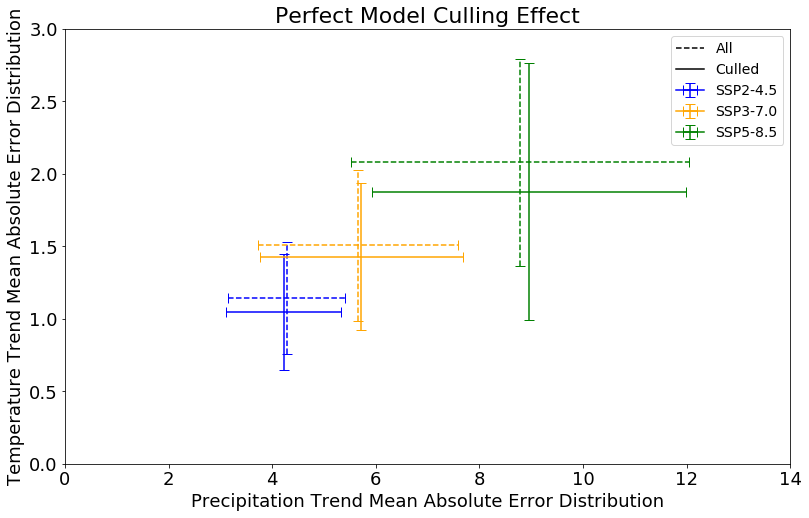

In [18]:
# Plot the effect of culling for all perfect models

#diro = '/glade/work/nlybarger/data/hydromet/ESM_eval_semifinal_plots/final/'
cols = ['blue','orange','green']
i=0
plt.figure(figsize=(13,8))
for exp in ['ssp245','ssp370','ssp585']:
    plt.errorbar(pmae_cull[exp], tmae_cull[exp], yerr=tmastd_cull[exp], xerr=pmastd_cull[exp],c=cols[i],capsize = 5,label=explab[i])
    a=plt.errorbar(pmae_all[exp], tmae_all[exp], yerr=tmastd_all[exp], xerr=pmastd_all[exp],c=cols[i],capsize=5)
    a[-1][0].set_linestyle('--')
    a[-1][1].set_linestyle('--')
    i=i+1
plt.plot([0,0],[0,0],linestyle='--',c='k',label='All')
plt.plot([0,0],[0,0],c='k',label='Culled')
plt.legend(fontsize=14)
plt.xlim([0,14])
plt.ylim([0,3.])
plt.xlabel('Precipitation Trend Mean Absolute Error Distribution',fontsize=18)
plt.ylabel('Temperature Trend Mean Absolute Error Distribution',fontsize=18)
plt.title('Perfect Model Culling Effect',fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('/glade/u/home/nlybarger/CMIP6.PNW.perfectModelEval_cullingEffect.png',dpi=450,bbox_inches='tight',facecolor='w')

In [ ]:
# ptrend_cull = {}
# ttrend_cull = {}
# ptrend_all = {}
# ttrend_all = {}
# ptrend_cull_diff = ttrend_cull_diff = ptrend_all_diff = ttrend_all_diff = np.zeros(nmod)

# for ip in range(nmod):
#     ptrend_cull[models[ip]] = 0.
#     ttrend_cull[models[ip]] = 0.
#     ptrend_all[models[ip]] = 0.
#     ttrend_all[models[ip]] = 0.
#     for iv in range(nmod):
#         if iv == 0:
#             continue
#         else:
#             if iv < 20.:
#                 ptrend_cull[models[ip]] += metrics[models[indy[ip,iv]]]['ptrend'].mean(dim='ens').data
#                 ttrend_cull[models[ip]] += metrics[models[indy[ip,iv]]]['ttrend'].mean(dim='ens').data
#             ptrend_all[models[ip]] += metrics[models[indy[ip,iv]]]['ptrend'].mean(dim='ens').data
#             ttrend_all[models[ip]] += metrics[models[indy[ip,iv]]]['ttrend'].mean(dim='ens').data
            
#     ptrend_cull_diff[ip] = ptrend_cull[models[ip]] - metrics[models[ip]]['ptrend'].mean(dim='ens')
#     ttrend_cull_diff[ip] = ttrend_cull[models[ip]] - metrics[models[ip]]['ttrend'].mean(dim='ens')
#     ptrend_all_diff[ip] = ptrend_all[models[ip]] - metrics[models[ip]]['ptrend'].mean(dim='ens')
#     ttrend_all_diff[ip] = ttrend_all[models[ip]] - metrics[models[ip]]['ttrend'].mean(dim='ens')

In [33]:
ranky = np.zeros((nmod,nmod))
for ip in range(nmod):
    for i in range(nmod):
        if ip == i:
            ranky[ip,i] = np.nan
        else:
            ranky[ip,i] = np.where(i==indy[ip,:])[0][0]

In [34]:
rankmean = np.nanmean(ranky,axis=0)
rankmed = np.nanmedian(ranky,axis=0)
rankstd = np.nanstd(ranky,axis=0)
rankmin = np.full(nmod,np.nan)
rankmax = np.full(nmod,np.nan)
for i in range(nmod):
    rankmin[i] = np.nanmin(ranky[:,i])
    rankmax[i] = np.nanmax(ranky[:,i])

In [35]:
ranksort = sorted(rankmean)
rankind = np.zeros(nmod,dtype=int)
ranklab = ['0']*nmod
for i in range(nmod):
    rankind[i] = int(np.where(ranksort[i]==rankmean)[0][0])
    ranklab[i] = models[rankind[i]]

In [ ]:
# for i in range(nmod):
#     print(ranklab[i])

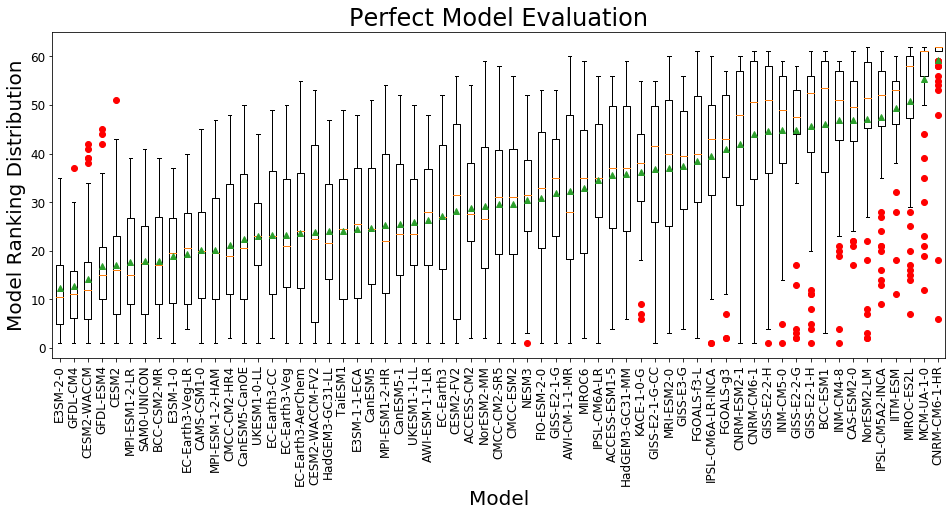

In [37]:
# Plot perfect model evaluation ranking distributions

diro = '/glade/work/nlybarger/data/hydromet/ESM_eval_semifinal_plots/final/'
plt.figure(figsize=(16,6))
x = np.arange(nmod)

for i in range(nmod):
    tempo = ranky[:,rankind[i]]
    tempo = tempo[~np.isnan(tempo)]
    plt.boxplot(tempo,vert=True,positions=np.array([x[i]]),widths=0.5,sym='r',showmeans=True)
plt.xticks(ticks=np.arange(nmod),labels=ranklab,rotation=90,fontsize=9)
plt.ylabel('Model Ranking Distribution',fontsize=20)
plt.xlabel('Model',fontsize=20)
plt.title('Perfect Model Evaluation',fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(diro + 'CMIP6.PNW+global.perfectModelEval.png',dpi=450,bbox_inches='tight',facecolor='w')